In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
color_pal = sns.color_palette()

<Axes: title={'center': 'PJME energy consumption HRL'}, xlabel='Datetime'>

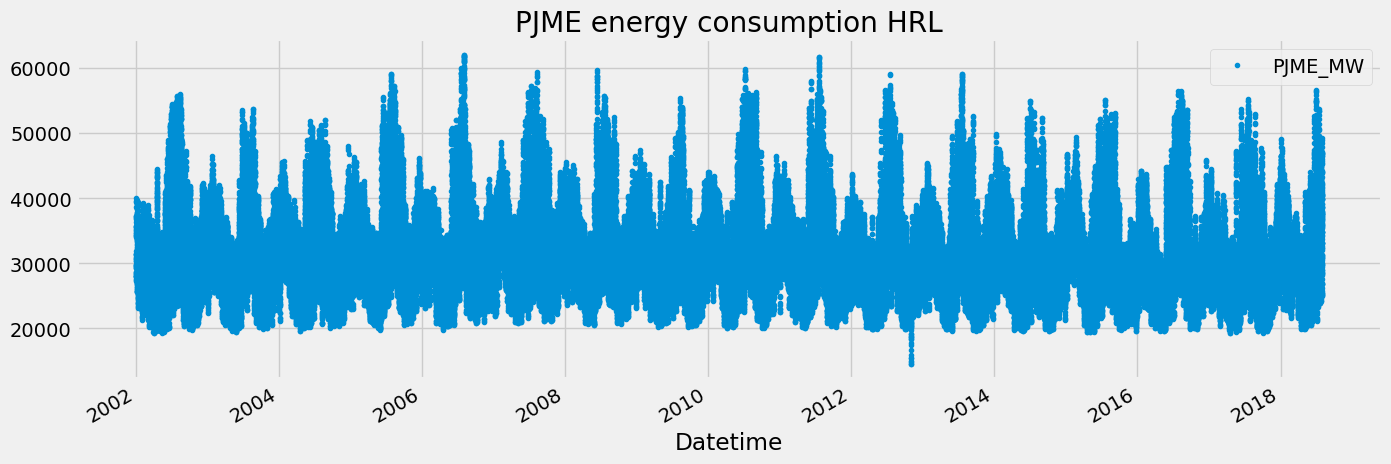

In [4]:
df.plot(style = '.', figsize=(15,5), color= color_pal[0], title="PJME energy consumption HRL"  )

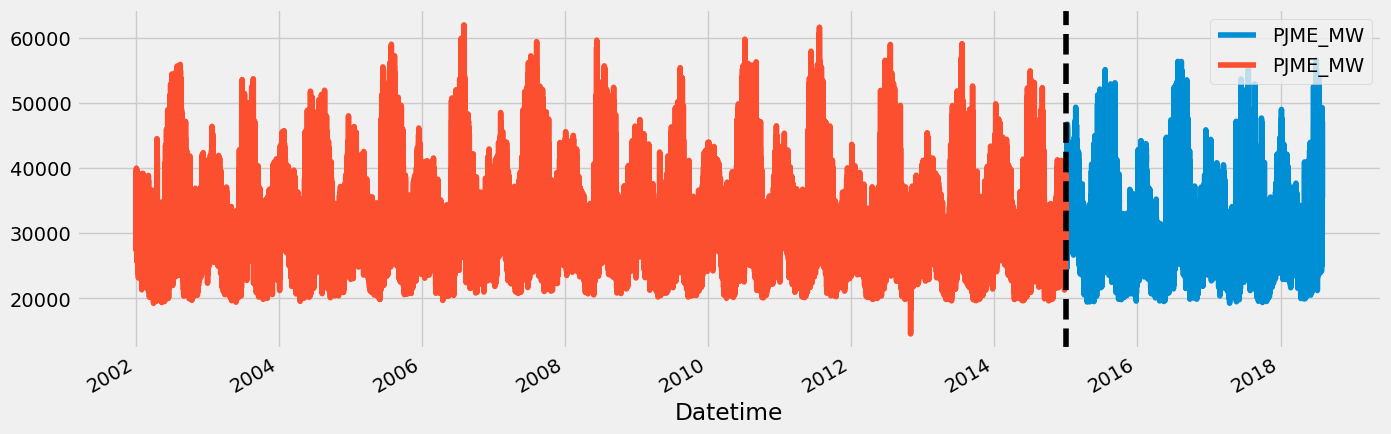

In [5]:
train = df.loc[df.index > '01-01-2015']
test = df.loc[df.index <= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label= 'training set')
test.plot(ax=ax, label = 'testing set')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

<Axes: xlabel='Datetime'>

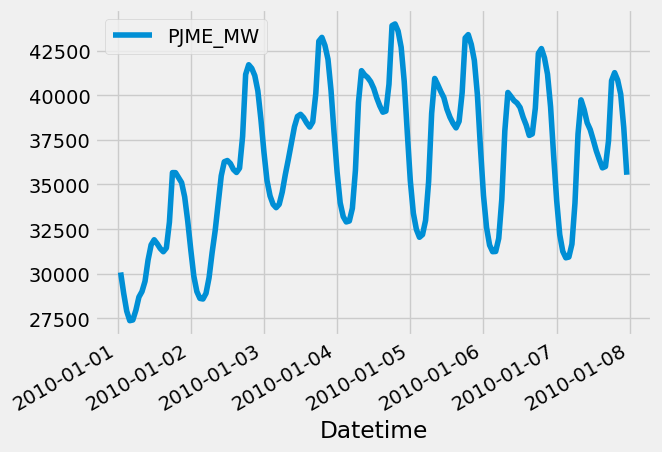

In [6]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot()

In [22]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

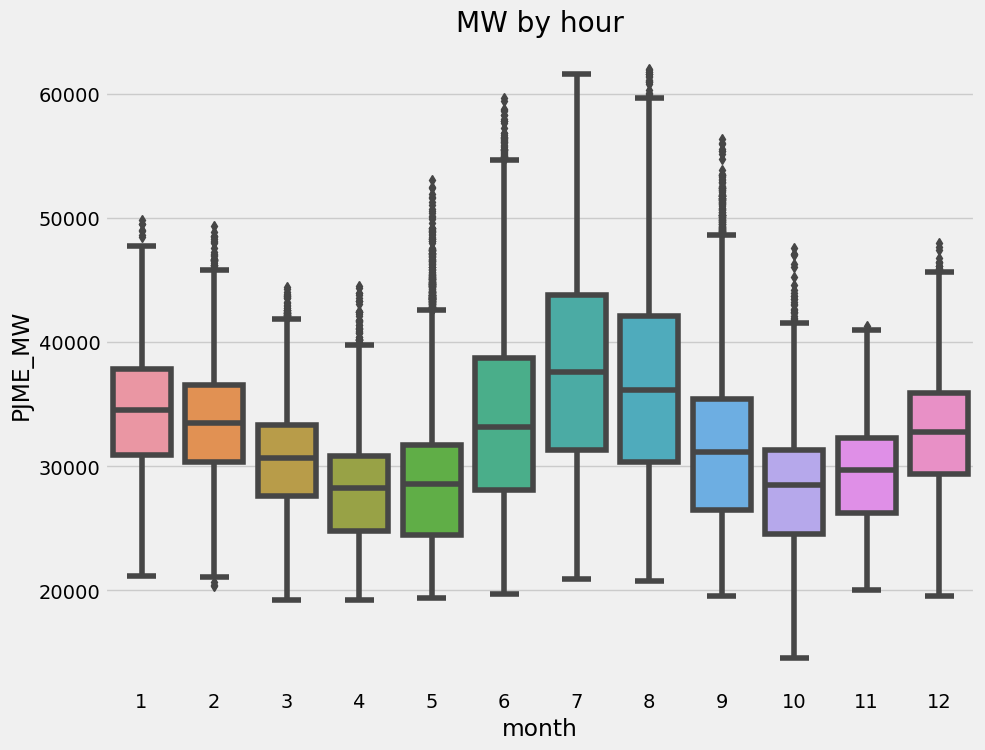

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data= df, x='month', y='PJME_MW')
ax.set_title('MW by hour')
plt.show()

In [28]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET = 'PJME_MW'
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [35]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:31666.52608	validation_1-rmse:32612.66401
[100]	validation_0-rmse:12300.30863	validation_1-rmse:13167.77456
[200]	validation_0-rmse:5837.39368	validation_1-rmse:6499.93084
[300]	validation_0-rmse:4052.77881	validation_1-rmse:4501.53775
[400]	validation_0-rmse:3603.18237	validation_1-rmse:3978.72059
[500]	validation_0-rmse:3435.48459	validation_1-rmse:3817.89864
[600]	validation_0-rmse:3342.84447	validation_1-rmse:3761.22334
[700]	validation_0-rmse:3271.67286	validation_1-rmse:3737.09396
[800]	validation_0-rmse:3216.53844	validation_1-rmse:3724.35589
[900]	validation_0-rmse:3175.43839	validation_1-rmse:3709.56264
[999]	validation_0-rmse:3142.75084	validation_1-rmse:3694.11596


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

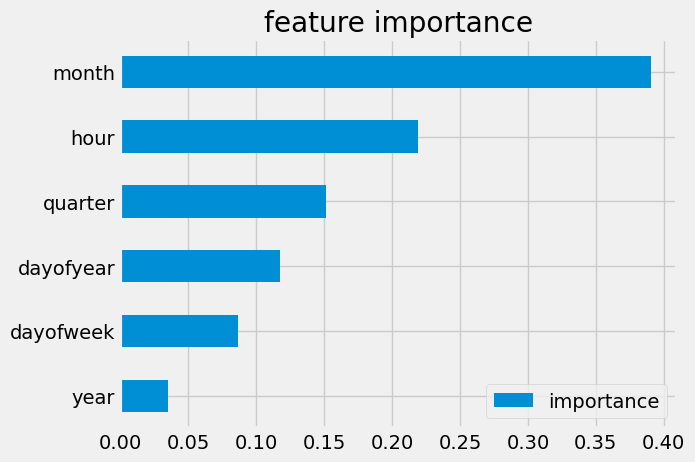

In [36]:
Fi= pd.DataFrame(data= reg.feature_importances_,
             index = reg.feature_names_in_,
columns=['importance'])
Fi.sort_values('importance').plot(kind='barh', title='feature importance')
plt.show()
 


In [37]:
reg.predict(X_test)

array([24758.908, 23963.35 , 23637.271, ..., 34997.613, 33122.11 ,
       30863.234], dtype=float32)

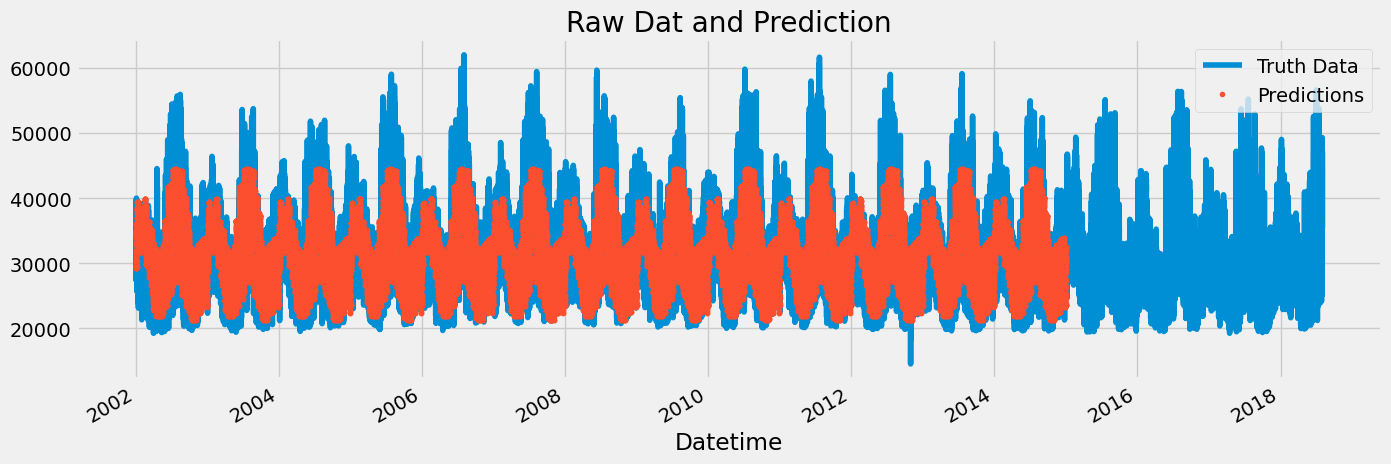

In [39]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


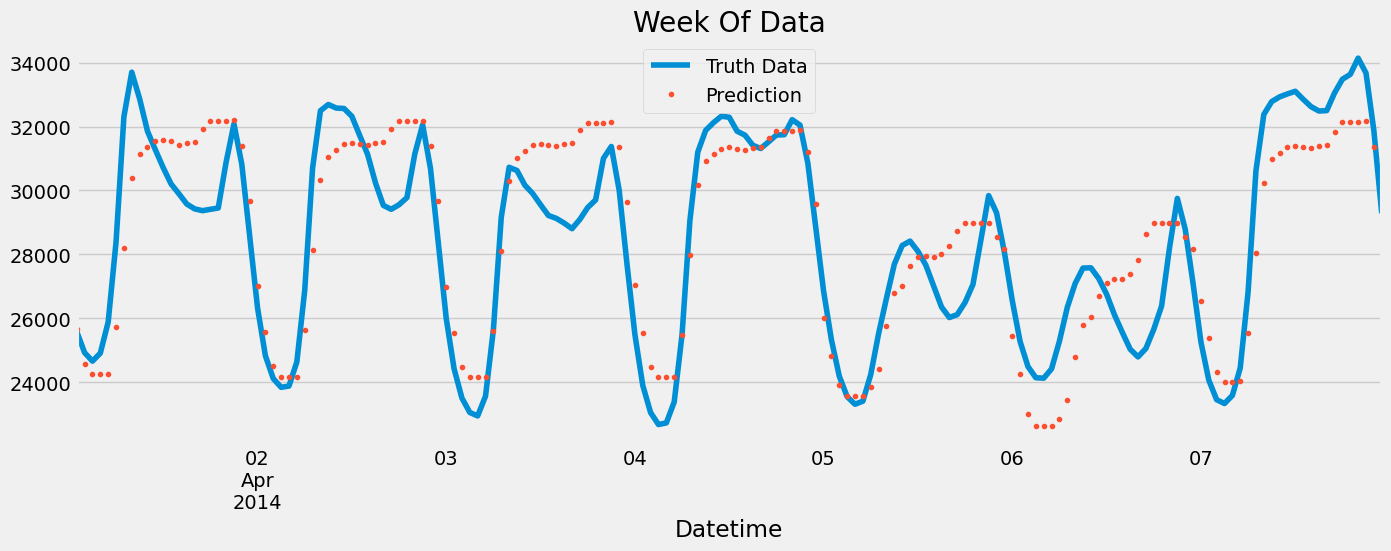

In [41]:
ax = df.loc[(df.index > '04-01-2014') & (df.index < '04-08-2014')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2014') & (df.index < '04-08-2014')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [44]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3694.12


In [45]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2008-06-09    15883.105062
2006-08-02    14823.384196
2006-08-03    14445.625895
2011-06-09    14320.449382
2008-06-10    14129.113770
2011-07-22    13993.744629
2011-07-23    12722.600179
2006-08-01    12600.574788
2008-06-08    12540.148519
2008-12-22    11778.537598
Name: error, dtype: float64